# TimeSeries Drifter Data - Quick Plot - Multideployment

From an erddap Dataset, specify the Drifter IDs to get a quick plot of the data

In [5]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [6]:
server_url = 'http://ecofoci-field.pmel.noaa.gov:8082/erddap'
dataset_name = {'2024':'2024_Argos_Drifters_NRT',
                '2025':'2025_Argos_Drifters_NRT',
               }

In [7]:
pdf = {}             

In [8]:
e = ERDDAP(server=server_url,
          protocol='tabledap',
          response='csv')

for ds,dn in enumerate(dataset_name):
        
    e.dataset_id=dataset_name[dn]
    
    df = e.to_pandas(
                index_col='time (UTC)',
                parse_dates=True,
                skiprows=(1,)  # units information can be dropped.
            )
    df.columns = [x.split()[0] for x in df.columns]
    pdf.update({dn:df})

In [10]:
#237948
pdf['2024'].

,trajectory_id,strain,voltage,latitude,sst,location_quality,lon360,longitude
time (UTC),,,,,,,,
2023-12-31 00:08:00+00:00,199996,0.0,13.2,57.242,5.56,1.0,218.816,-141.184
2023-12-31 00:11:00+00:00,199996,0.0,13.2,57.244,5.56,1.0,218.816,-141.184
2023-12-31 00:21:00+00:00,199996,0.0,13.2,57.242,5.56,1.0,218.817,-141.183
2023-12-31 00:54:00+00:00,199996,0.0,13.2,57.243,5.56,2.0,218.796,-141.204
2023-12-31 00:49:00+00:00,199996,0.0,13.2,57.244,8.12,3.0,218.792,-141.208
...,...,...,...,...,...,...,...,...
2024-11-26 02:52:00+00:00,281544,12.0,15.8,44.699,6.40,3.0,296.404,-63.596
2024-11-26 04:19:00+00:00,281544,8.0,15.8,44.699,6.44,3.0,296.405,-63.595
2024-11-26 08:18:00+00:00,281544,3.0,15.8,44.701,6.36,3.0,296.406,-63.594


In [14]:
for datasets in pdf:
    pdf[datasets] = pdf[datasets][pdf[datasets]['trajectory_id'] == 237948] 


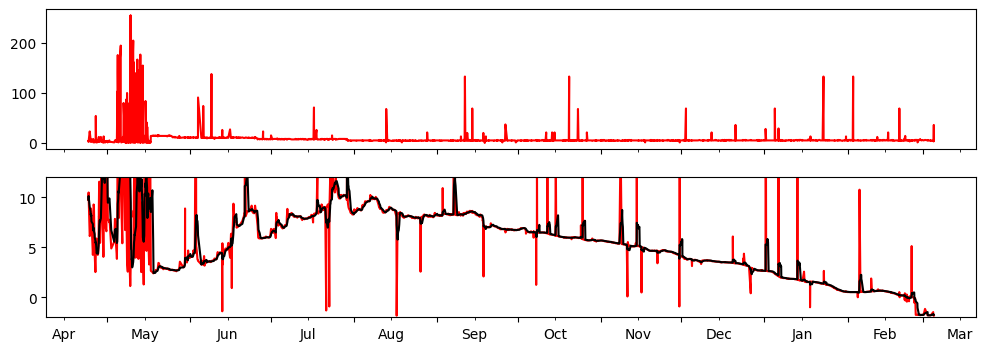

In [59]:
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter

fig, ax = plt.subplots(2,figsize=(12, 4),sharex=True)
for datasets in pdf:
    tdf = pdf[datasets][pdf[datasets].location_quality == 1]
    ax[0].plot(tdf.index,tdf.strain,'r')
    ax[1].plot(tdf.index,tdf.sst,'r')
    ax[1].plot(tdf.sort_index().rolling('1D').mean().index,
               tdf.sort_index().rolling('1D').mean().sst,'k')

ax[1].set_ylim([-2,12])
# xfmt = mdates.DateFormatter('%d-%b')
ax[1].xaxis.set_major_locator(MonthLocator(bymonth=range(1,13,1)))
ax[1].xaxis.set_minor_locator(MonthLocator(bymonth=range(1,13,1),bymonthday=15))
ax[1].xaxis.set_minor_formatter(DateFormatter('%b'))
ax[1].xaxis.set_major_formatter(DateFormatter(''))
ax[1].xaxis.set_tick_params(which='major', pad=3)
ax[1].xaxis.set_tick_params(which='minor', pad=5)

In [56]:
tdf.sort_index().rolling('1D').mean().sst.max()

5.803999999999999

In [63]:
import pygmt
import matplotlib as mpl
import cmocean

cmap = plt.cm.magma  # define the colormap
# extract all colors from the .jet map
num=48
cmaplist = [mpl.colors.to_hex(cmap(i)) for i in range(0,cmap.N,int(cmap.N/num))]

In [79]:
fig = pygmt.Figure()

fig.coast(region=[-180, -150, 55, 62.5], projection='B-165/65/40/60/6i', land='lightgray', water='gray',
          frame=True)

In [80]:
count=0
for traj in pdf.keys():
    fig.plot(x=pdf[traj].longitude, y=pdf[traj].latitude, cmap=cmaplist[count], style='p0.0125')
    print(cmaplist[count]+"\t : \t"+str(traj))
    count+=1

#000004	 : 	2024
#02020b	 : 	2025


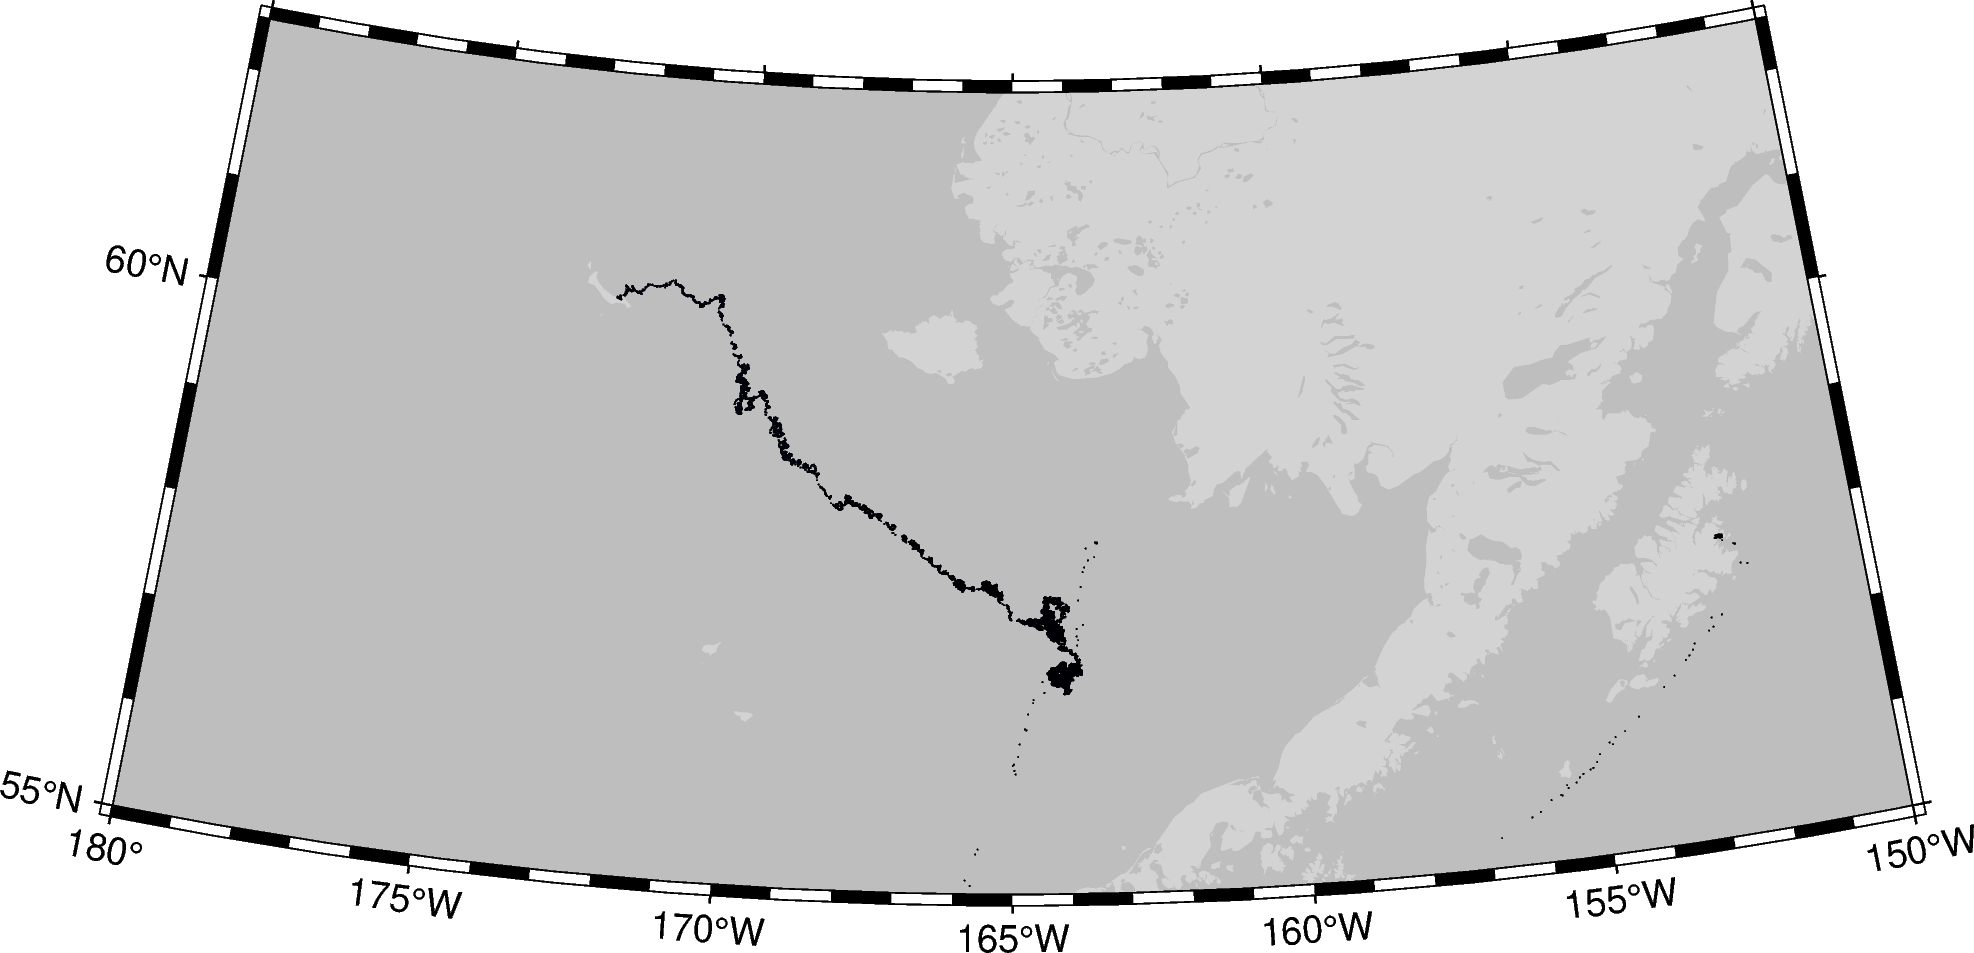

In [81]:
fig.show()